#**Task 1: Sentiment Labeling**

##**Objective**

Label each employee message with one of three sentiment categories: Positive, Negative, or Neutral.

* **Approach**

  We used a pre-trained Hugging Face transformer model to classify the sentiment of each message.

* **Model**

  Model name: cardiffnlp/twitter-roberta-base-sentiment

  Type: RoBERTa-based transformer fine-tuned for sentiment classification.

* **Output labels:**

  LABEL_0 → Negative

  LABEL_1 → Neutral

  LABEL_2 → Positive

In [1]:
import pandas as pd
from transformers import pipeline

In [29]:
df = pd.read_excel("/content/test.xlsx")
classifier = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")

label_map = {
    "LABEL_0": "Negative",
    "LABEL_1": "Neutral",
    "LABEL_2": "Positive"
}

# Function to classify sentiment
def get_sentiment(text):
    if not isinstance(text, str) or text.strip() == "":
        return "Neutral"
    result = classifier(text[:512])[0]
    return label_map[result["label"]]


df["sentiment"] = df["body"].apply(get_sentiment)
df.to_excel("test_with_sentiment.xlsx", index=False)

print("Sentiment labeling complete! File saved as test_with_sentiment.xlsx")
print(df)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cpu


Sentiment labeling complete! File saved as test_with_sentiment.xlsx
                                                Subject  \
0                                  EnronOptions Update!   
1                                          (No Subject)   
2          Phone Screen  Interview - Shannon L. Burnham   
3                                 RE: My new work email   
4                                                   Bet   
...                                                 ...   
2186                                         Re: Resume   
2187  Final Schedule - Wednesday, May 2, 2001 - Jesu...   
2188                                       (No Subject)   
2189                                      League is Set   
2190                                 AirCard Activation   

                                                   body       date  \
0     EnronOptions Announcement\n\n\nWe have updated... 2010-05-10   
1     Marc,\n\nUnfortunately, today is not going to ... 2010-07-29   
2     When: W

#**Task 2: Exploratory Data Analysis (EDA)**

##**Objective**

Understand the structure, distribution, and trends in the dataset through thorough exploration.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

**1. Load the dataset (from task 1)**




In [3]:
df = pd.read_excel("test_with_sentiment.xlsx")

**2. Overall Data Structure/Information**

In [4]:
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Subject    2191 non-null   object        
 1   body       2191 non-null   object        
 2   date       2191 non-null   datetime64[ns]
 3   from       2191 non-null   object        
 4   sentiment  2191 non-null   object        
dtypes: datetime64[ns](1), object(4)
memory usage: 85.7+ KB
None
Subject      0
body         0
date         0
from         0
sentiment    0
dtype: int64


*As we can see except date column, all of the other data is object type without any null values.*

**3. Trend Over Time**

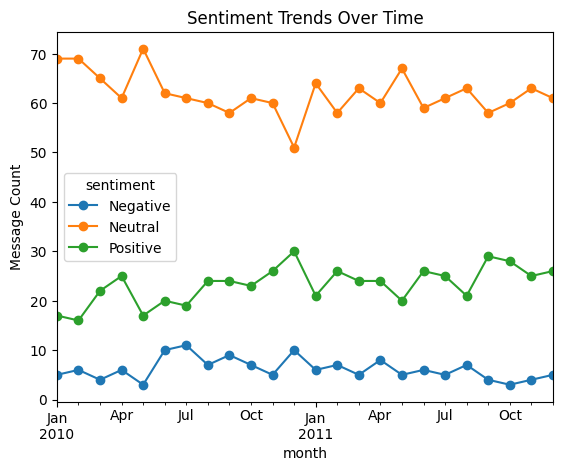

In [5]:
df["month"] = df["date"].dt.to_period("M")

monthly_trends = df.groupby(["month", "sentiment"]).size().unstack(fill_value=0)
monthly_trends.plot(kind="line", marker="o", title="Sentiment Trends Over Time")
plt.ylabel("Message Count")
plt.show()

*We can see that overall number of neutral/positive/negative messages tendency stayed the same where neutral messages are the most followed by positive and the least is negative at any point in time.*



**4.  Message Length Analysis**

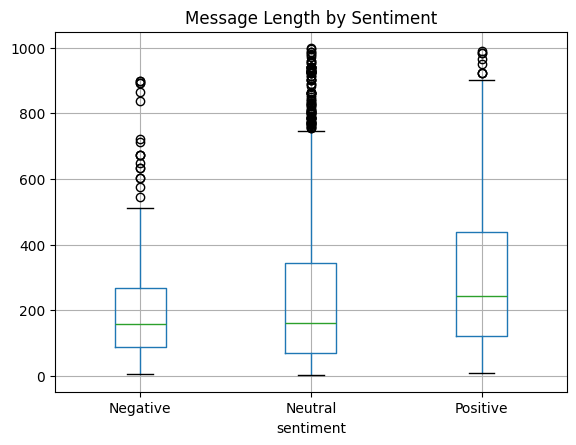

In [6]:
df["msg_length"] = df["body"].astype(str).apply(len)
df.boxplot(column="msg_length", by="sentiment")
plt.title("Message Length by Sentiment")
plt.suptitle("")
plt.show()

*From this boxplot we can conclude the following:

**Shortest on average:** Negative messages with median is around ~150 words/characters and most messages fall between ~80 and ~250.

**Longest on average**: Positive messages with higher median around ~200–220, wider spread ~120 to ~400, showing that positive messages are generally longer and more variable..

**Most variable with extreme outliers:** Neutral messages with median ~150, (slightly lower than negative), wider IQR, ~70 to ~300, suggesting more variation in length..*



**5. Top Senders**

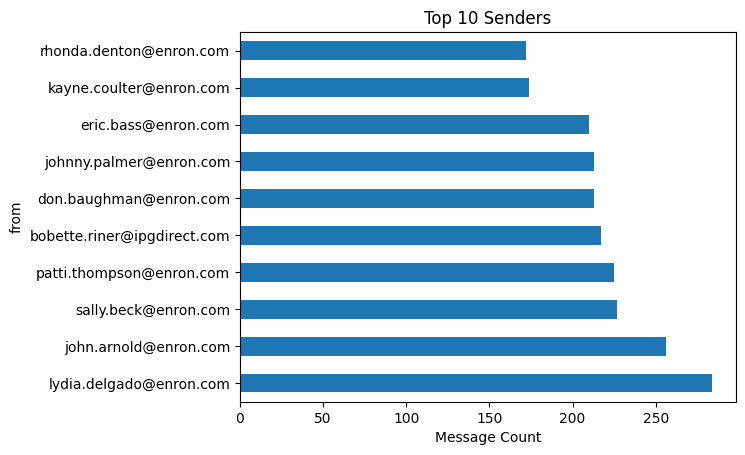

In [7]:
top_senders = df["from"].value_counts().head(10)
top_senders.plot(kind="barh", title="Top 10 Senders")
plt.xlabel("Message Count")
plt.show()


#**Task 3: Employee Score Calculation**

##**Objective**

Compute a monthly sentiment score for each employee based on their messages.

In [33]:
df = pd.read_excel("/content/test_with_sentiment.xlsx")

# Rename for clarity
if "from" in df.columns:
    df = df.rename(columns={"from": "employee"})

# Preprocess
df["date"] = pd.to_datetime(df["date"])
df["sentiment"] = df["sentiment"].str.capitalize()

# Add column for score (-1, 0, 1)
score_map = {"Positive": 1, "Negative": -1, "Neutral": 0}
df["sent_score"] = df["sentiment"].map(score_map)

# Add year-month column
df["year_month"] = df["date"].dt.to_period("M").astype(str)

# Aggregate by employee + month
monthly = df.groupby(["employee", "year_month"]).agg(
    monthly_score=("sent_score", "sum"),   # total score
    msg_count=("sent_score", "count")      # number of messages
).reset_index()

#Illustration (data)
monthly

# Save it as file
monthly.to_csv("/content/monthly_scores.csv", index=False)

,employee,year_month,monthly_score,msg_count
0,bobette.riner@ipgdirect.com,2010-01,0,2
1,bobette.riner@ipgdirect.com,2010-02,4,14
2,bobette.riner@ipgdirect.com,2010-03,1,11
3,bobette.riner@ipgdirect.com,2010-04,1,6
4,bobette.riner@ipgdirect.com,2010-05,2,4
...,...,...,...,...
235,sally.beck@enron.com,2011-08,-1,14
236,sally.beck@enron.com,2011-09,0,1
237,sally.beck@enron.com,2011-10,4,7
238,sally.beck@enron.com,2011-11,3,8


#**Task 4: Employee Ranking**

##**Objective**

Generate ranked lists of employees based on their monthly sentiment scores.

In [30]:
ranking_rows = []
for ym, g in monthly.groupby("year_month"):
    top_pos = g.sort_values(["monthly_score", "employee"], ascending=[False, True]).head(3)
    top_pos["rank_type"] = "Top Positive"
    top_pos["rank_position"] = range(1, len(top_pos) + 1)

    top_neg = g.sort_values(["monthly_score", "employee"], ascending=[True, True]).head(3)
    top_neg["rank_type"] = "Top Negative"
    top_neg["rank_position"] = range(1, len(top_neg) + 1)

    ranking_rows.append(pd.concat([top_pos, top_neg]))

rankings_df = pd.concat(ranking_rows).reset_index(drop=True)

#Illustration (data)
rankings_df

rankings_df = pd.concat(ranking_rows).reset_index(drop=True)
rankings_df.to_csv("/content/monthly_rankings.csv", index=False)

,employee,year_month,monthly_score,msg_count,rank_type,rank_position
0,eric.bass@enron.com,2010-01,3,10,Top Positive,1
1,patti.thompson@enron.com,2010-01,3,10,Top Positive,2
2,don.baughman@enron.com,2010-01,2,9,Top Positive,3
3,sally.beck@enron.com,2010-01,-1,9,Top Negative,1
4,bobette.riner@ipgdirect.com,2010-01,0,2,Top Negative,2
...,...,...,...,...,...,...
139,lydia.delgado@enron.com,2011-12,4,17,Top Positive,2
140,rhonda.denton@enron.com,2011-12,4,11,Top Positive,3
141,bobette.riner@ipgdirect.com,2011-12,0,3,Top Negative,1
142,don.baughman@enron.com,2011-12,0,7,Top Negative,2


#**Task 5: Flight Risk Identification**

##**Objective**

Compute a monthly sentiment score for each employee based on their messages.

In [23]:
if "from" in df.columns:
    df = df.rename(columns={"from": "employee"})

df["date"] = pd.to_datetime(df["date"])
df["sentiment"] = df["sentiment"].str.capitalize()

flight_rows = []

for emp, group in df.groupby("employee"):
    neg_dates = group.loc[group["sentiment"] == "Negative", "date"].sort_values().reset_index(drop=True)
    for i in range(len(neg_dates)):
        window = neg_dates[(neg_dates >= neg_dates[i]) & (neg_dates <= neg_dates[i] + pd.Timedelta(days=30))]
        if len(window) >= 4:
            flight_rows.append({
                "employee": emp,
                "window_start": window.min().date(),
                "window_end": window.max().date(),
                "neg_count": len(window)
            })

flight_df = pd.DataFrame(flight_rows).drop_duplicates()

flight_df

,employee,window_start,window_end,neg_count
0,bobette.riner@ipgdirect.com,2010-07-15,2010-08-11,4
1,don.baughman@enron.com,2010-12-12,2010-12-28,4
2,john.arnold@enron.com,2010-05-25,2010-06-21,4
3,sally.beck@enron.com,2011-08-15,2011-08-25,4


#**Task 6: Predictive Modeling**

##**Objective**

Develop a linear regression model to analyze sentiment trends and predict sentiment scores using a variety of independent variables that may influence sentiment scores.

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [45]:

if "from" in df.columns:
    df = df.rename(columns={"from": "employee"})

# Preprocess
df["date"] = pd.to_datetime(df["date"])
df["body"] = df["body"].astype(str)
df["msg_len"] = df["body"].apply(len)
df["word_count"] = df["body"].apply(lambda x: len(x.split()))
df["sentiment"] = df["sentiment"].str.capitalize()

# Sentiment score column
score_map = {"Positive": 1, "Negative": -1, "Neutral": 0}
df["sent_score"] = df["sentiment"].map(score_map)

# Add year-month
df["year_month"] = df["date"].dt.to_period("M").astype(str)

# Aggregate by employee + month
monthly = df.groupby(["employee", "year_month"]).agg(
    monthly_score=("sent_score", "sum"),       # Target variable
    msg_count=("sent_score", "count"),         # Number of messages
    total_len=("msg_len", "sum"),              # Total message length
    avg_len=("msg_len", "mean"),               # Avg message length
    avg_words=("word_count", "mean")           # Avg word count
).reset_index()

# Define features and target
features = ["msg_count", "total_len", "avg_len", "avg_words"]
X = monthly[features]
y = monthly["monthly_score"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear regression model
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)

print("Task 6 Results")
print("--------------")
print("R²:", r2)
print("MSE:", mse)
print("RMSE:", rmse)

Task 6 Results
--------------
R²: 0.20609476406327099
MSE: 3.2138689824574094
RMSE: 3.2138689824574094
